<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">             <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Armin Ghasemi</b><br><br>810100198</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>deep learning </b><br><br>HW_4 Q2</i></font></h1>
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#045F5F"> <b>Amirhossein samoudi </b><br><br>810100108</i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
           </tr>
        </table>
    </div>
</div>


### imports

In [34]:
import os
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import glob
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from torchinfo import summary
import torch.nn.functional as F

### mount drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data):
    if isinstance(data, tuple) or isinstance(data, list):
        return tuple(d.to(device) for d in data)
    return data.to(device)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

input_dim = 21
seq_len = 6
batch_size = 64
hidden_dim = 128

### State-Space Markov Event prediction

In [5]:
class MarkovMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.model(x)


summary(MarkovMLP(input_dim).to(device), input_size=(batch_size, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
MarkovMLP                                [64, 21]                  --
├─Sequential: 1-1                        [64, 21]                  --
│    └─Linear: 2-1                       [64, 128]                 2,816
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 21]                  2,709
Total params: 5,525
Trainable params: 5,525
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.35
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.02
Estimated Total Size (MB): 0.10

### LSTM

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1])


model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
summary(model, input_size=(batch_size, seq_len, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [64, 21]                  --
├─LSTM: 1-1                              [64, 6, 128]              77,312
├─Sequential: 1-2                        [64, 21]                  --
│    └─Linear: 2-1                       [64, 128]                 16,512
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 21]                  2,709
Total params: 96,533
Trainable params: 96,533
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 30.92
Input size (MB): 0.03
Forward/backward pass size (MB): 0.47
Params size (MB): 0.39
Estimated Total Size (MB): 0.89

### BiLSTM

In [7]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1])

summary(BiLSTMModel(input_dim).to(device), input_size=(batch_size, seq_len, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMModel                              [64, 21]                  --
├─LSTM: 1-1                              [64, 6, 256]              154,624
├─Sequential: 1-2                        [64, 21]                  --
│    └─Linear: 2-1                       [64, 128]                 32,896
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 21]                  2,709
Total params: 190,229
Trainable params: 190,229
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 61.65
Input size (MB): 0.03
Forward/backward pass size (MB): 0.86
Params size (MB): 0.76
Estimated Total Size (MB): 1.66

### GRU

In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        out, _ = self.gru(x)
        return self.head(out[:, -1])

summary(GRUModel(input_dim).to(device), input_size=(batch_size, seq_len, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [64, 21]                  --
├─GRU: 1-1                               [64, 6, 128]              57,984
├─Sequential: 1-2                        [64, 21]                  --
│    └─Linear: 2-1                       [64, 128]                 16,512
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 21]                  2,709
Total params: 77,205
Trainable params: 77,205
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 23.50
Input size (MB): 0.03
Forward/backward pass size (MB): 0.47
Params size (MB): 0.31
Estimated Total Size (MB): 0.81

### BiGRU

In [9]:
class BiGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        out, _ = self.gru(x)
        return self.head(out[:, -1])

summary(BiGRUModel(input_dim).to(device), input_size=(batch_size, seq_len, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BiGRUModel                               [64, 21]                  --
├─GRU: 1-1                               [64, 6, 256]              115,968
├─Sequential: 1-2                        [64, 21]                  --
│    └─Linear: 2-1                       [64, 128]                 32,896
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 21]                  2,709
Total params: 151,573
Trainable params: 151,573
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 46.81
Input size (MB): 0.03
Forward/backward pass size (MB): 0.86
Params size (MB): 0.61
Estimated Total Size (MB): 1.50

### Data preparation and statistical analysis

In [ ]:
file_path = '/content/drive/MyDrive/HW4-Q2-Dataset/val_data.csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,236,236,128.0,96.0,36.2800,149.0,113.0,92.0,28.5,33.029605,...,378.146104,726.000000,27.92,1,0.0,1.0,-0.03,237,0,9
1,237,237,129.0,94.0,37.0425,136.0,102.0,83.0,28.0,33.029605,...,376.746753,729.666667,27.92,1,0.0,1.0,-0.03,238,0,9
2,238,238,133.0,94.0,37.8050,141.0,106.0,86.0,33.0,33.029605,...,375.347403,733.333333,27.92,1,0.0,1.0,-0.03,239,0,9
3,239,239,137.0,94.0,38.5675,142.0,106.0,87.0,30.0,33.029605,...,373.948052,737.000000,27.92,1,0.0,1.0,-0.03,240,0,9
4,240,240,138.0,96.0,39.3300,142.0,108.0,87.0,30.5,33.029605,...,372.548701,740.666667,27.92,1,0.0,1.0,-0.03,241,0,9


In [ ]:
for col in df.columns:
    print(col)

Unnamed: 0
Hour
HR
O2Sat
Temp
SBP
MAP
DBP
Resp
EtCO2
BaseExcess
HCO3
FiO2
pH
PaCO2
SaO2
AST
BUN
Alkalinephos
Calcium
Chloride
Creatinine
Bilirubin_direct
Glucose
Lactate
Magnesium
Phosphate
Potassium
Bilirubin_total
TroponinI
Hct
Hgb
PTT
WBC
Fibrinogen
Platelets
Age
Gender
Unit1
Unit2
HospAdmTime
ICULOS
SepsisLabel
Patient_ID


### Correlation Matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 82/82 [00:00<00:00, 94.43it/s]


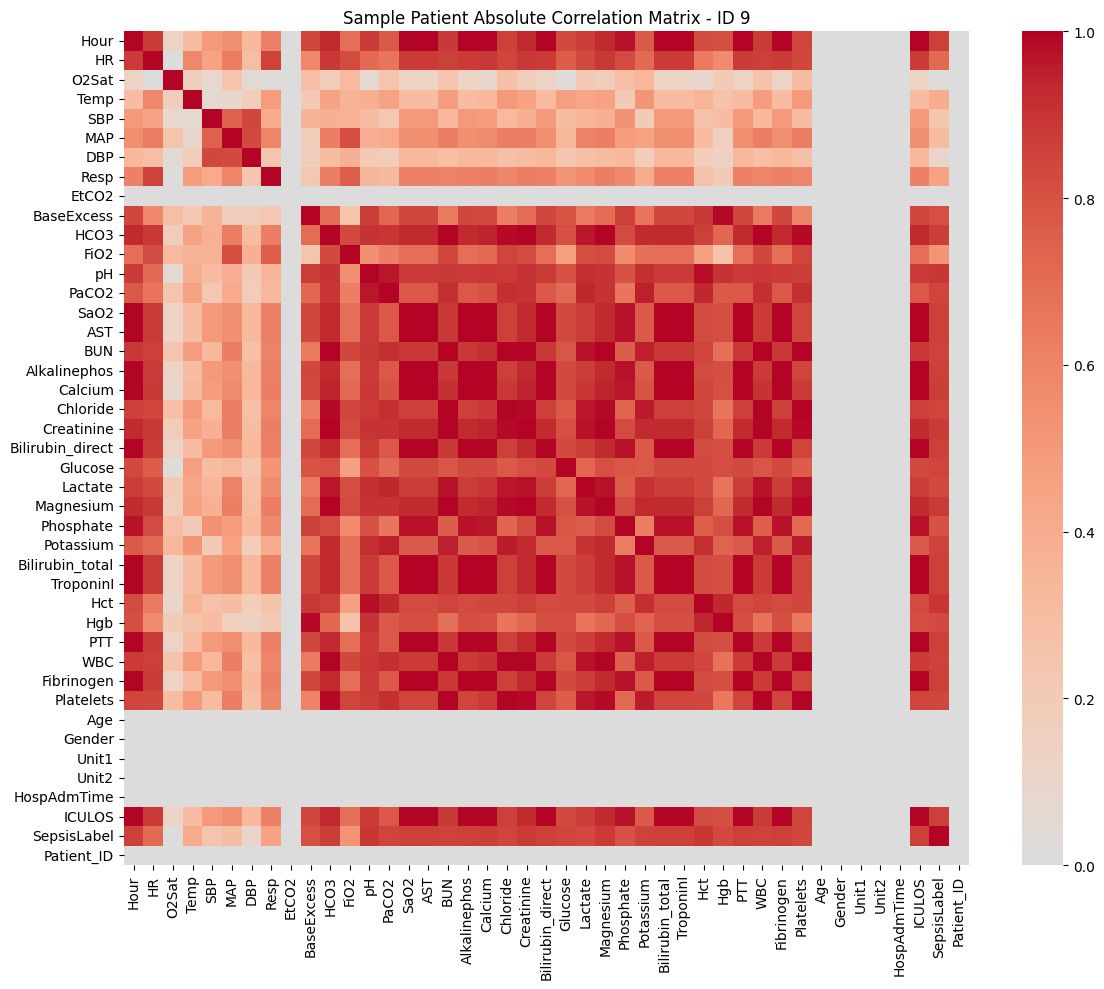

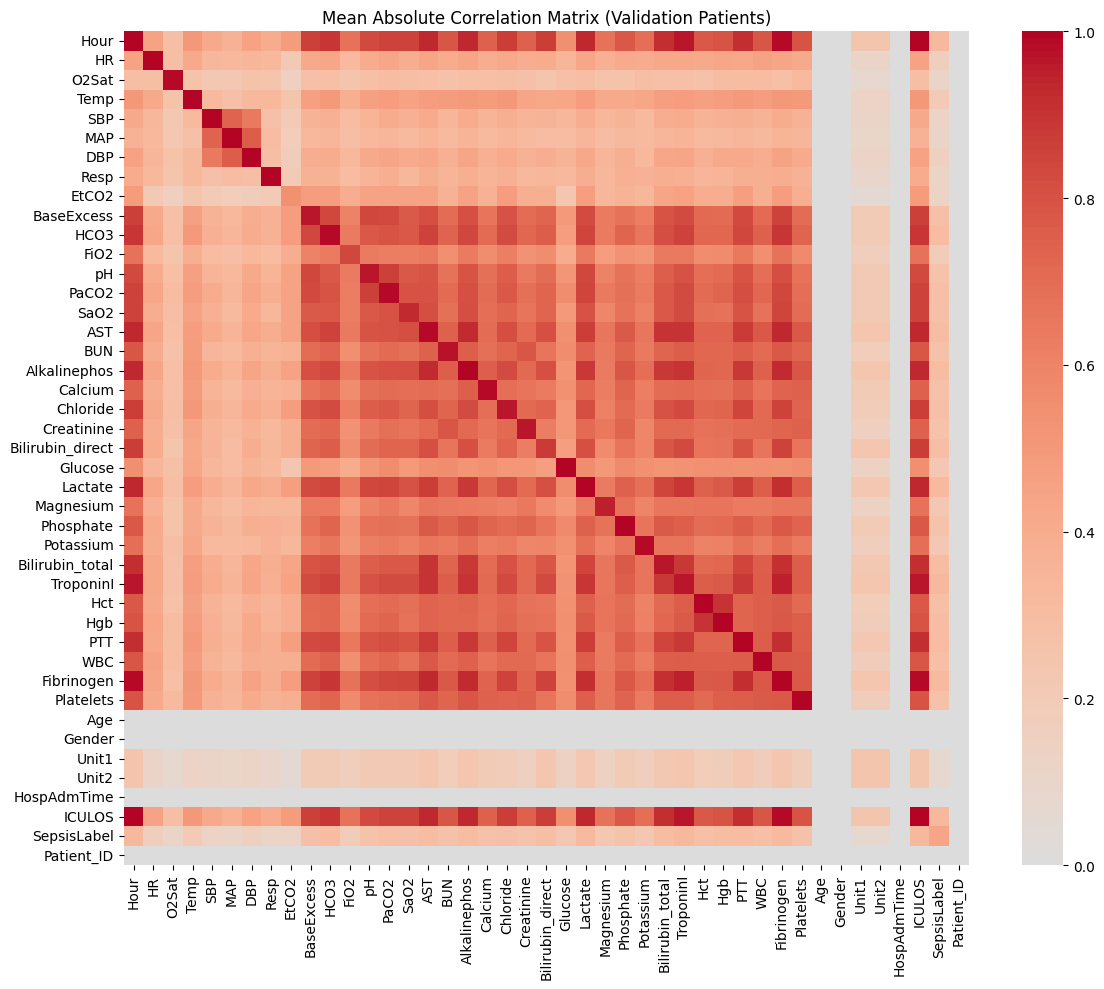

In [ ]:
# Step 1: Mount Google Drive and load val data
drive.mount('/content/drive')
val_df = pd.read_csv('/content/drive/MyDrive/HW4-Q2-Dataset/val_data.csv')

# Step 2: Drop only truly useless columns (keep 'Hour')
drop_cols = ['Unnamed: 0']
data_cols = [col for col in val_df.columns if col not in drop_cols]

# Step 3: Compute per-patient absolute correlation matrices
correlation_matrices = []
sample_corr = None
sample_pid = None

for pid in tqdm(val_df['Patient_ID'].unique()):
    patient_df = val_df[val_df['Patient_ID'] == pid][data_cols].reset_index(drop=True)

    if patient_df.shape[0] < 2:
        continue

    num_df = patient_df.select_dtypes(include=np.number)
    corr = num_df.corr().fillna(0).abs()  # abs correlation

    if corr.shape[0] != len(num_df.columns):
        continue

    corr_matrix = corr.to_numpy()
    correlation_matrices.append(corr_matrix)

    if sample_corr is None:
        sample_corr = corr_matrix
        sample_pid = pid
        sample_cols = num_df.columns

# Step 4: Compute mean absolute correlation
correlation_stack = np.stack(correlation_matrices)
mean_corr = np.mean(correlation_stack, axis=0)
mean_abs_corr_df = pd.DataFrame(mean_corr, index=sample_cols, columns=sample_cols)

# Step 5: Plot heatmap for sample patient
plt.figure(figsize=(12, 10))
sns.heatmap(sample_corr, xticklabels=sample_cols, yticklabels=sample_cols, cmap='coolwarm', center=0)
plt.title(f'Sample Patient Absolute Correlation Matrix - ID {sample_pid}')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 6: Plot heatmap of mean abs correlation
plt.figure(figsize=(12, 10))
sns.heatmap(mean_abs_corr_df, cmap='coolwarm', center=0)
plt.title('Mean Absolute Correlation Matrix (Validation Patients)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Drop columns not considered for correlation
drop_cols = ['Age', 'Gender', 'HospAdmTime']
filtered_corr_df = mean_abs_corr_df.drop(index=drop_cols, columns=drop_cols)

# STEP 1: Remove redundant highly-correlated pairs
high_corr_threshold = 0.9
features_to_drop = set()
features = filtered_corr_df.columns.tolist()

# Collect highly correlated pairs
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        a, b = features[i], features[j]
        corr_val = filtered_corr_df.loc[a, b]
        if corr_val >= high_corr_threshold:
            # Compare total correlation with other features
            a_total = filtered_corr_df.loc[a].sum()
            b_total = filtered_corr_df.loc[b].sum()
            if a_total > b_total:
                features_to_drop.add(a)
            else:
                features_to_drop.add(b)

remaining_features = [f for f in features if f not in features_to_drop]


# Remove Patient_ID and Hour from remaining_features if present
filtered_features = [f for f in remaining_features if f not in ['Patient_ID', 'Hour']]

# Compute total correlation
remaining_corr_df = filtered_corr_df.loc[filtered_features, filtered_features]
total_corr = remaining_corr_df.sum()
sorted_features = total_corr.sort_values().index.tolist()

# Select exactly 20 most independent features (excluding Patient_ID and Hour)
least_corr_features = sorted_features[:20]

# Final list includes 22 columns: Patient_ID, Hour, 20 selected features
final_features = ['Patient_ID', 'Hour'] + least_corr_features

print("✅ Final 22 selected features (1 ID + 1 Hour + 20 independent):")
print(final_features)



✅ Final 22 selected features (1 ID + 1 Hour + 20 independent):
['Patient_ID', 'Hour', 'Unit2', 'Unit1', 'SepsisLabel', 'O2Sat', 'EtCO2', 'Resp', 'MAP', 'SBP', 'HR', 'DBP', 'Temp', 'Glucose', 'FiO2', 'Magnesium', 'Potassium', 'Creatinine', 'Calcium', 'Bilirubin_direct', 'Hct', 'BUN']


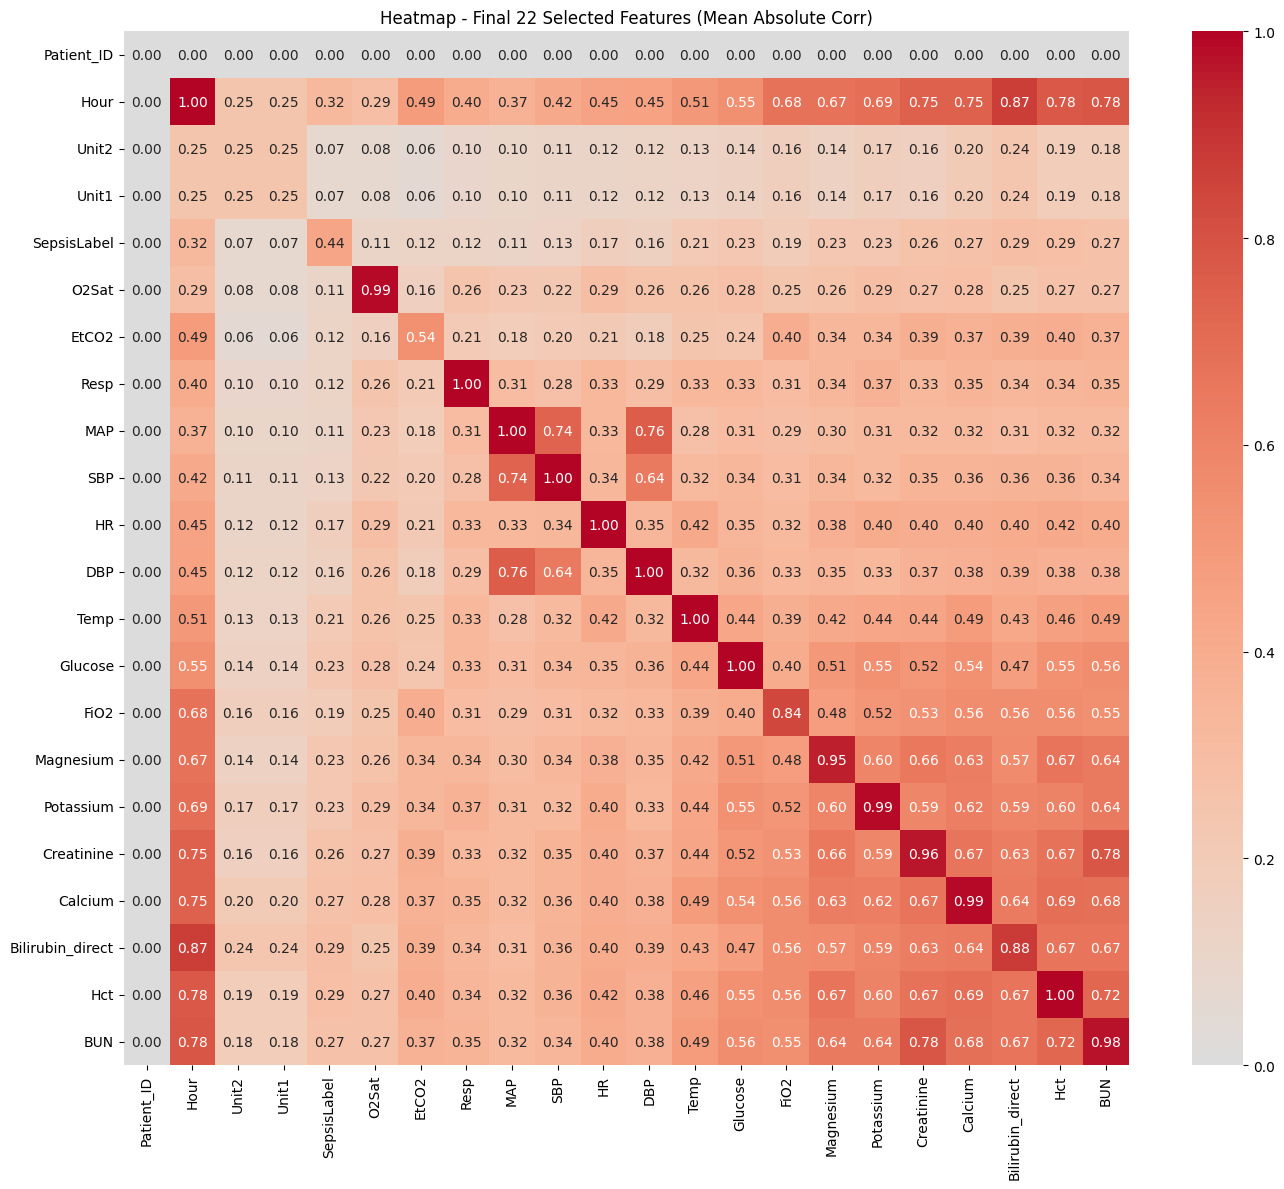

In [ ]:
final_corr_df = mean_abs_corr_df.loc[final_features, final_features]

plt.figure(figsize=(14, 12))
sns.heatmap(final_corr_df, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Heatmap - Final 22 Selected Features (Mean Absolute Corr)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Final 22 selected features (from earlier step)
# final_features = ['Patient_ID', 'Hour'] + 20 least-correlated features
# Make sure it's defined
assert 'final_features' in globals(), "You need to define final_features first!"

# Paths
data_dir = '/content/drive/MyDrive/HW4-Q2-Dataset'
splits = ['train', 'val', 'test']
data_paths = {split: os.path.join(data_dir, f"{split}_data.csv") for split in splits}
save_base_dir = '/content/drive/MyDrive/selected_patient_time_series'
os.makedirs(save_base_dir, exist_ok=True)

# Save per-patient files
for split in splits:
    df = pd.read_csv(data_paths[split])
    df = df.loc[:, ~df.columns.duplicated()]

    # Filter to final 22 features
    selected_cols = [col for col in final_features if col in df.columns]
    df = df[selected_cols]

    # Create directory for this split
    split_save_dir = os.path.join(save_base_dir, split)
    os.makedirs(split_save_dir, exist_ok=True)

    print(f"Saving files for {split} split...")
    for pid in tqdm(df['Patient_ID'].unique(), desc=f"{split}"):
        patient_df = df[df['Patient_ID'] == pid].reset_index(drop=True)

        # Drop Patient_ID from columns before saving
        patient_df = patient_df.drop(columns=['Patient_ID'])

        # Save file
        save_path = os.path.join(split_save_dir, f"patient_{int(pid)}.csv")
        patient_df.to_csv(save_path, index=False)

print("✅ All files saved.")


Saving files for train split...


train: 100%|██████████| 656/656 [00:08<00:00, 75.58it/s]


Saving files for val split...


val: 100%|██████████| 82/82 [00:01<00:00, 59.56it/s]


Saving files for test split...


test: 100%|██████████| 29/29 [00:00<00:00, 79.96it/s]

✅ All files saved.


### SARIMAX

Longest patient file: /content/drive/MyDrive/selected_patient_time_series/train/patient_9.csv  (136 rows)


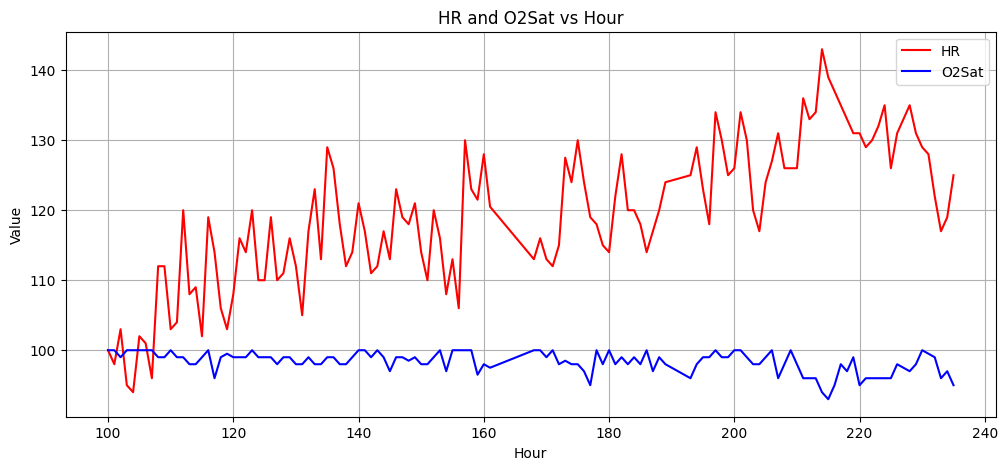

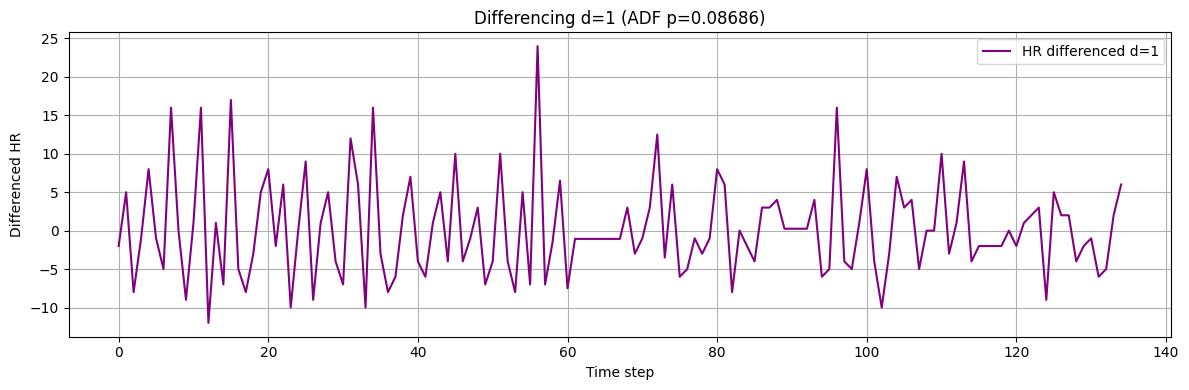

Final differencing order (d): 1  (ADF p=0.00000)


In [ ]:
# Step 1: Find the longest time series in train
train_dir = '/content/drive/MyDrive/selected_patient_time_series/train'

max_len = 0
longest_file = None

for fname in os.listdir(train_dir):
    fpath = os.path.join(train_dir, fname)
    df = pd.read_csv(fpath)
    if df.shape[0] > max_len:
        max_len = df.shape[0]
        longest_file = fpath

# Step 2: Load the longest file
df = pd.read_csv(longest_file)
print(f"Longest patient file: {longest_file}  ({df.shape[0]} rows)")

# Step 3: Plot HR and O2Sat vs Hour
plt.figure(figsize=(12, 5))
plt.plot(df['Hour'], df['HR'], label='HR', color='red')
plt.plot(df['Hour'], df['O2Sat'], label='O2Sat', color='blue')
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title("HR and O2Sat vs Hour")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: ADF test loop with differencing and plotting
def adf_p(series):
    return adfuller(series.dropna(), autolag='AIC')[1]

hr_series = df['HR']
d = 0
p = adf_p(hr_series)

while p >= 0.05:
    d += 1
    hr_series = hr_series.diff().dropna()

    plt.figure(figsize=(12, 4))
    plt.plot(hr_series.values, label=f'HR differenced d={d}', color='purple')
    plt.title(f'Differencing d={d} (ADF p={p:.5f})')
    plt.xlabel('Time step')
    plt.ylabel('Differenced HR')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    p = adf_p(hr_series)

print(f"Final differencing order (d): {d}  (ADF p={p:.5f})")


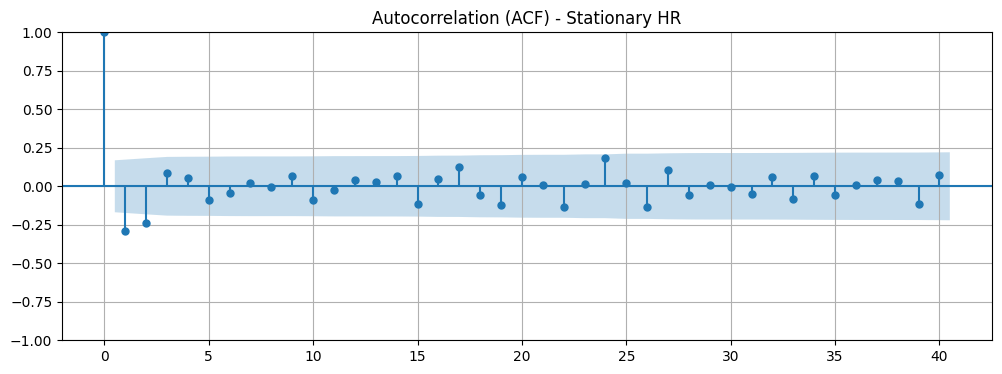

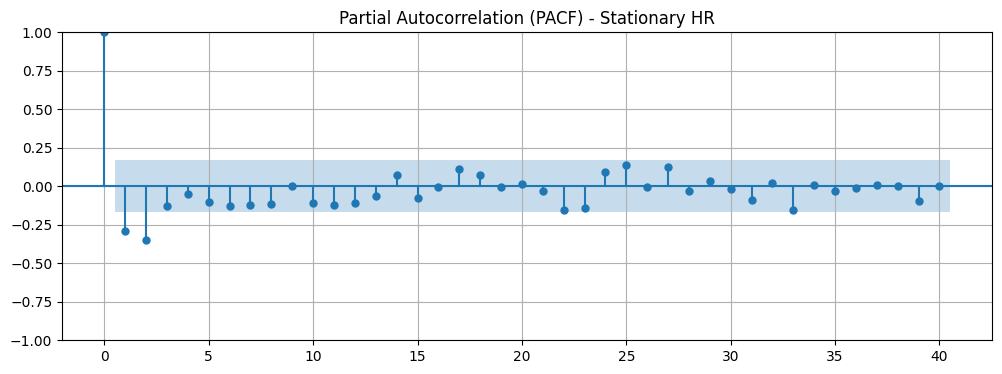

   AR (from PACF) ≈ 2
   MA (from ACF)  ≈ 2


In [ ]:
# Compute full ACF and PACF arrays
acf_vals = acf(hr_series, nlags=40)
pacf_vals = pacf(hr_series, nlags=40, method='ywm')

# Find first significant drop (after lag 0)
def first_significant_drop(values, threshold=0.2):
    for lag in range(1, len(values)):
        if abs(values[lag]) < threshold:
            return lag
    return None

ma_order = first_significant_drop(acf_vals) -1
ar_order = first_significant_drop(pacf_vals) -1

# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(hr_series, lags=40, ax=plt.gca())
plt.title("Autocorrelation (ACF) - Stationary HR")
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(hr_series, lags=40, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation (PACF) - Stationary HR")
plt.grid(True)
plt.show()

print(f"   AR (from PACF) ≈ {ar_order}")
print(f"   MA (from ACF)  ≈ {ma_order}")


Using patient file: /content/drive/MyDrive/selected_patient_time_series/train/patient_9.csv  (136 rows)
Using differencing order d = 1 (ADF p = 0.00000)


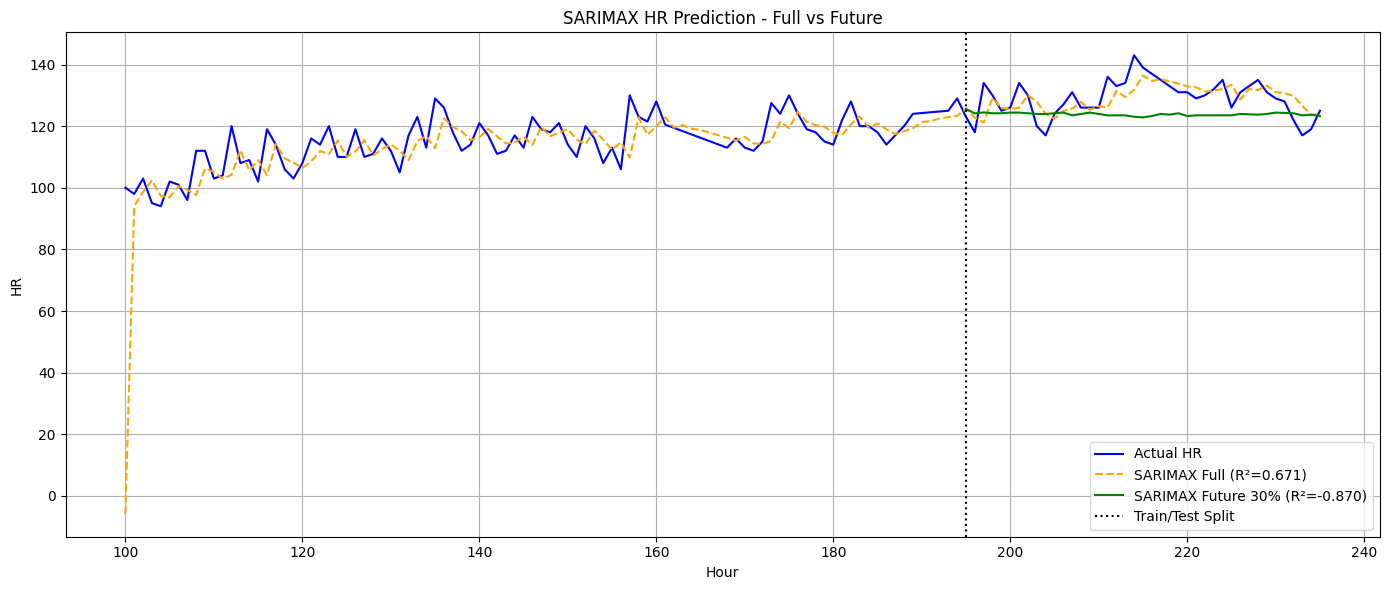


✅ Final R² scores:
Full model (reconstruction): R² = 0.6715
Split model (future prediction): R² = -0.8700


In [ ]:
# Load longest patient file from train
train_dir = '/content/drive/MyDrive/selected_patient_time_series/train'
max_len = 0
longest_file = None

for fname in os.listdir(train_dir):
    fpath = os.path.join(train_dir, fname)
    df = pd.read_csv(fpath)
    if df.shape[0] > max_len:
        max_len = df.shape[0]
        longest_file = fpath

df = pd.read_csv(longest_file)
print(f"Using patient file: {longest_file}  ({df.shape[0]} rows)")

# Extract HR and O2Sat
hr = df['HR'].astype(float)
o2 = df['O2Sat'].astype(float)
hours = df['Hour'].values

# Determine differencing order d
def adf_p(series):
    return adfuller(series.dropna(), autolag='AIC')[1]

d = 0
p_val = adf_p(hr)
hr_diff = hr.copy()

while p_val >= 0.05:
    d += 1
    hr_diff = hr_diff.diff().dropna()
    p_val = adf_p(hr_diff)

print(f"Using differencing order d = {d} (ADF p = {p_val:.5f})")

# Fixed AR, MA order
p = 2
q = 2

# ----------- Model 1: Full series fit and prediction -----------
model1 = SARIMAX(hr, exog=o2, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
result1 = model1.fit(disp=False)
pred1 = result1.predict(start=0, end=len(hr)-1, exog=o2)
r2_full = r2_score(hr[d:], pred1[d:])  # remove first d points due to differencing

# ----------- Model 2: Train on 70%, predict 30% -----------
split_idx = int(len(hr) * 0.7)
hr_train, hr_test = hr[:split_idx], hr[split_idx:]
o2_train, o2_test = o2[:split_idx], o2[split_idx:]
hour_train, hour_test = hours[:split_idx], hours[split_idx:]

model2 = SARIMAX(hr_train, exog=o2_train, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
result2 = model2.fit(disp=False)

# Predict 30% future values
pred2 = result2.predict(start=split_idx, end=len(hr)-1, exog=o2_test)
r2_split = r2_score(hr_test[d:], pred2[d:])  # align for differencing

# ----------- Plot all together -----------
plt.figure(figsize=(14, 6))

# Original HR
plt.plot(hours, hr, label='Actual HR', color='blue')

# Full model prediction
plt.plot(hours, pred1, label=f'SARIMAX Full (R²={r2_full:.3f})', color='orange', linestyle='--')

# 30% future prediction from split model
plt.plot(hour_test, pred2, label=f'SARIMAX Future 30% (R²={r2_split:.3f})', color='green')

# Highlight split area
plt.axvline(hours[split_idx], color='black', linestyle=':', label='Train/Test Split')

plt.xlabel("Hour")
plt.ylabel("HR")
plt.title("SARIMAX HR Prediction - Full vs Future")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Report
print("\n✅ Final R² scores:")
print(f"Full model (reconstruction): R² = {r2_full:.4f}")
print(f"Split model (future prediction): R² = {r2_split:.4f}")


In [ ]:
# Paths
base_dir = '/content/drive/MyDrive/selected_patient_time_series'
splits = ['train', 'val', 'test']

# Determine numeric continuous features (train only)
train_dir = os.path.join(base_dir, 'train')
sample_train = pd.read_csv(os.path.join(train_dir, os.listdir(train_dir)[0]))
feature_cols = sample_train.columns.tolist()

# Separate Hour for special treatment
hour_col = 'Hour'
non_hour_cols = [col for col in feature_cols if col != hour_col]

# Detect binary vs continuous
binary_cols = []
continuous_cols = []

for col in non_hour_cols:
    unique_vals = set()
    for fname in os.listdir(train_dir):
        fpath = os.path.join(train_dir, fname)
        df = pd.read_csv(fpath)
        if col in df.columns:
            unique_vals.update(df[col].dropna().unique())
        if len(unique_vals) > 10:
            break  # skip if clearly continuous

    if unique_vals.issubset({0, 1}):
        binary_cols.append(col)
    else:
        continuous_cols.append(col)

print(f"Continuous features: {continuous_cols}")
print(f"Binary features: {binary_cols}")

# Fit scaler on all train data (excluding Hour)
scaler = MinMaxScaler()

train_data = []
for fname in os.listdir(train_dir):
    df = pd.read_csv(os.path.join(train_dir, fname))
    train_data.append(df[continuous_cols])

train_concat = pd.concat(train_data, axis=0)
scaler.fit(train_concat)

# Apply normalization to all splits
for split in splits:
    split_dir = os.path.join(base_dir, split)
    new_dir = os.path.join(base_dir, f"{split}_normalized")
    os.makedirs(new_dir, exist_ok=True)

    print(f"Processing {split} set...")
    for fname in tqdm(os.listdir(split_dir)):
        df = pd.read_csv(os.path.join(split_dir, fname))

        # Normalize Hour locally per patient
        if 'Hour' in df.columns:
            hour = df['Hour']
            df['Hour'] = (hour - hour.min()) / (hour.max() - hour.min() + 1e-8)

        # Normalize continuous columns with train scaler
        if continuous_cols:
            df[continuous_cols] = scaler.transform(df[continuous_cols])

        # Save to new file
        df.to_csv(os.path.join(new_dir, fname), index=False)

print("✅ Normalization complete.")


Continuous features: ['Unit2', 'Unit1', 'O2Sat', 'EtCO2', 'Resp', 'MAP', 'SBP', 'HR', 'DBP', 'Temp', 'Glucose', 'FiO2', 'Magnesium', 'Potassium', 'Creatinine', 'Calcium', 'Bilirubin_direct', 'Hct', 'BUN']
Binary features: ['SepsisLabel']
Processing train set...


100%|██████████| 656/656 [00:16<00:00, 40.12it/s]


Processing val set...


100%|██████████| 82/82 [00:01<00:00, 42.73it/s]


Processing test set...


100%|██████████| 29/29 [00:00<00:00, 40.79it/s]

✅ Normalization complete.


### Training deep learning models

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data_dir, input_length):
        self.samples = []
        for fname in os.listdir(data_dir):
            df = pd.read_csv(os.path.join(data_dir, fname)).values.astype(np.float32)
            for i in range(len(df) - input_length):
                x = df[i:i+input_length]
                y = df[i+input_length]
                self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y)


In [11]:
class MarkovDataset(Dataset):
    def __init__(self, data_dir):
        self.samples = []
        for fname in os.listdir(data_dir):
            df = pd.read_csv(os.path.join(data_dir, fname)).values.astype(np.float32)
            for i in range(len(df) - 1):
                x = df[i]
                y = df[i + 1]
                self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [12]:

def train_and_evaluate(
    model, train_loader, val_loader, test_loader,
    epochs=50, initial_lr=5e-3, min_lr=1e-5, lr_patience=5, early_stop_patience=10,
    dynamic_lr=True, optimizer_type='adam'
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr) if optimizer_type.lower() == 'adam' \
        else torch.optim.SGD(model.parameters(), lr=initial_lr)
    mse_loss = nn.MSELoss().to(device)

    best_val_loss = float('inf')
    best_model_state = None
    train_losses, val_losses = [] , []
    no_improve_epochs = 0
    lr_no_improve = 0
    current_lr = initial_lr

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x, y in train_loader:
            x, y = to_device(x), to_device(y)
            y_pred = model(x)
            loss = mse_loss(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = to_device(x), to_device(y)
                y_pred = model(x)
                loss = mse_loss(y_pred, y)
                total_val_loss += loss.item()
        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:>2}/{epochs} | Train: {train_loss:.8f} | Val: {val_loss:.8f} | LR: {current_lr:.2e} | "
              f"No Improve: {no_improve_epochs} | LR Patience: {lr_no_improve}")

        # Early stopping + saving best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve_epochs = 0
            lr_no_improve = 0
            torch.save(best_model_state, f"best_model_{model.__class__.__name__}.pt")
            print("Best model updated and saved.")
        else:
            no_improve_epochs += 1
            lr_no_improve += 1

        # Learning rate reduction
        if dynamic_lr and lr_no_improve >= lr_patience:
            current_lr = max(current_lr / 2, min_lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            print("Learning rate reduced.")
            lr_no_improve = 0

        if no_improve_epochs >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Plot Losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluation
    model.load_state_dict(torch.load(f"best_model_{model.__class__.__name__}.pt"))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = to_device(x), to_device(y)
            y_pred.append(model(x).cpu())
            y_true.append(y.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    metrics = {
        'Loss': mean_squared_error(y_true, y_pred) + mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'Cosine': 1 - cosine_similarity(y_true, y_pred).mean()
    }
    return metrics



In [13]:
def train_markov_model(
    model, train_loader, val_loader, test_loader,
    epochs=50, initial_lr=5e-3, min_lr=1e-5, lr_patience=5, early_stop_patience=10,
    dynamic_lr=True, optimizer_type='adam'
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr) if optimizer_type.lower() == 'adam' \
        else torch.optim.SGD(model.parameters(), lr=initial_lr)
    mse_loss = nn.MSELoss().to(device)

    best_val_loss = float('inf')
    best_model_state = None
    train_losses, val_losses = [], []
    no_improve_epochs = 0
    lr_no_improve = 0
    current_lr = initial_lr

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for x, y in train_loader:
            x, y = to_device(x), to_device(y)

            # Handle shape for Markov: ensure batch x input_dim
            if isinstance(model, MarkovMLP):
                if x.ndim == 3:
                    x = x[:, -1, :]
                elif x.ndim == 1:
                    x = x.unsqueeze(0)

            y_pred = model(x)
            loss = mse_loss(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = to_device(x), to_device(y)

                if isinstance(model, MarkovMLP):
                    if x.ndim == 3:
                        x = x[:, -1, :]
                    elif x.ndim == 1:
                        x = x.unsqueeze(0)

                y_pred = model(x)
                loss = mse_loss(y_pred, y)
                total_val_loss += loss.item()
        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:>2}/{epochs} | Train: {train_loss:.8f} | Val: {val_loss:.8f} | LR: {current_lr:.2e} | "
              f"No Improve: {no_improve_epochs} | LR Patience: {lr_no_improve}")

        # Early stopping + best model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve_epochs = 0
            lr_no_improve = 0
            torch.save(best_model_state, f"best_model_{model.__class__.__name__}.pt")
            print("Best model updated and saved.")
        else:
            no_improve_epochs += 1
            lr_no_improve += 1

        # Learning rate adjustment
        if dynamic_lr and lr_no_improve >= lr_patience:
            current_lr = max(current_lr / 2, min_lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            print("Learning rate reduced.")
            lr_no_improve = 0

        if no_improve_epochs >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluation
    model.load_state_dict(torch.load(f"best_model_{model.__class__.__name__}.pt"))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = to_device(x), to_device(y)
            if isinstance(model, MarkovMLP):
                if x.ndim == 3:
                    x = x[:, -1, :]
                elif x.ndim == 1:
                    x = x.unsqueeze(0)
            preds = model(x).cpu()
            y_pred.append(preds)
            y_true.append(y.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    metrics = {
        'Loss': mean_squared_error(y_true, y_pred) + mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'Cosine': 1 - cosine_similarity(y_true, y_pred).mean()
    }
    return metrics


In [14]:
input_length = 6
batch_size = 32
input_dim = 21


train_dataset = TimeSeriesDataset('/content/drive/MyDrive/selected_patient_time_series/train_normalized', input_length)
val_dataset = TimeSeriesDataset('/content/drive/MyDrive/selected_patient_time_series/val_normalized', input_length)
test_dataset = TimeSeriesDataset('/content/drive/MyDrive/selected_patient_time_series/test_normalized', input_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataset_m = MarkovDataset('/content/drive/MyDrive/selected_patient_time_series/train_normalized')
val_dataset_m = MarkovDataset('/content/drive/MyDrive/selected_patient_time_series/val_normalized')
test_dataset_m = MarkovDataset('/content/drive/MyDrive/selected_patient_time_series/test_normalized')
train_loader_m = DataLoader(train_dataset_m, batch_size=batch_size, shuffle=False)
val_loader_m = DataLoader(val_dataset_m, batch_size=batch_size, shuffle=False)
test_loader_m = DataLoader(test_dataset_m, batch_size=batch_size, shuffle=False)



 Training MarkovMLP...
Epoch  1/100 | Train: 0.05761154 | Val: 0.02430382 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.01993400 | Val: 0.01823865 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.01529208 | Val: 0.01466376 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  4/100 | Train: 0.01261697 | Val: 0.01263812 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  5/100 | Train: 0.01108283 | Val: 0.01143720 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  6/100 | Train: 0.01012707 | Val: 0.01063418 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.00944905 | Val: 0.01002370 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.00891249 | Val: 0.00951779 | LR: 5.00e-03 | No Im

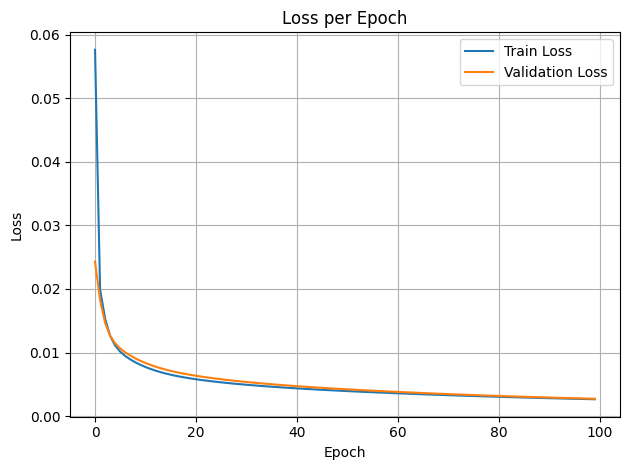


 Training LSTM...
Epoch  1/100 | Train: 0.11640869 | Val: 0.05282509 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.03784406 | Val: 0.03372531 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.03241612 | Val: 0.03298219 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  4/100 | Train: 0.03179234 | Val: 0.03240535 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  5/100 | Train: 0.03115733 | Val: 0.03170570 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  6/100 | Train: 0.03040934 | Val: 0.03087845 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.02951821 | Val: 0.02988448 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.02844004 | Val: 0.02867582 | LR: 5.00e-03 | No Improve

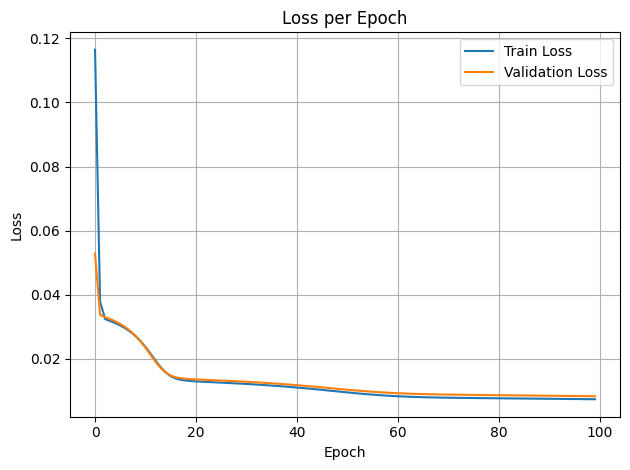


 Training BiLSTM...
Epoch  1/100 | Train: 0.12816326 | Val: 0.06451305 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.04278817 | Val: 0.03500749 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.03311814 | Val: 0.03355088 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  4/100 | Train: 0.03243378 | Val: 0.03309515 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  5/100 | Train: 0.03200870 | Val: 0.03267023 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  6/100 | Train: 0.03156911 | Val: 0.03219870 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.03106786 | Val: 0.03165307 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.03048111 | Val: 0.03100911 | LR: 5.00e-03 | No Impro

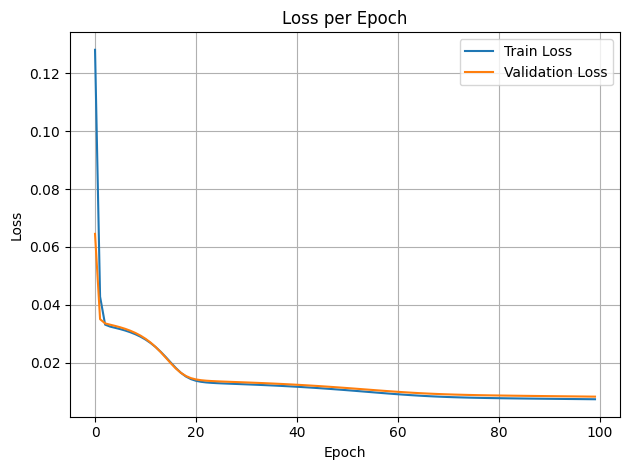


 Training GRU...
Epoch  1/100 | Train: 0.09035525 | Val: 0.03373703 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.03076847 | Val: 0.03071532 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.02850108 | Val: 0.02828991 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  4/100 | Train: 0.02586455 | Val: 0.02527146 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  5/100 | Train: 0.02266222 | Val: 0.02175106 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  6/100 | Train: 0.01917680 | Val: 0.01824401 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.01607900 | Val: 0.01553228 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.01397423 | Val: 0.01396034 | LR: 5.00e-03 | No Improve:

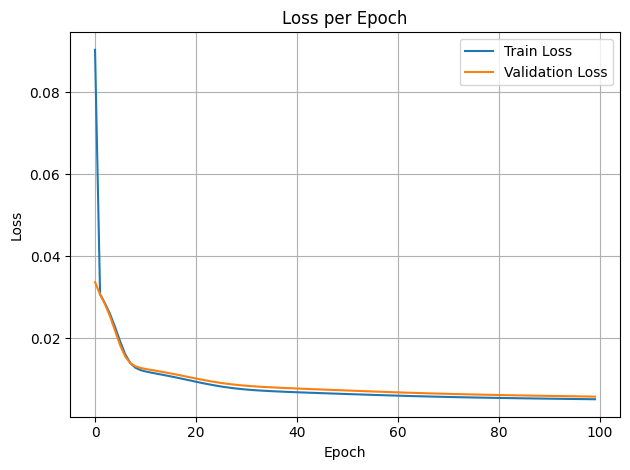


 Training BiGRU...
Epoch  1/100 | Train: 0.11064824 | Val: 0.03687753 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.03169111 | Val: 0.03144163 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.02956612 | Val: 0.02972860 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  4/100 | Train: 0.02766517 | Val: 0.02759294 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  5/100 | Train: 0.02533763 | Val: 0.02499650 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  6/100 | Train: 0.02257919 | Val: 0.02201781 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.01959525 | Val: 0.01901505 | LR: 5.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.01685274 | Val: 0.01653044 | LR: 5.00e-03 | No Improv

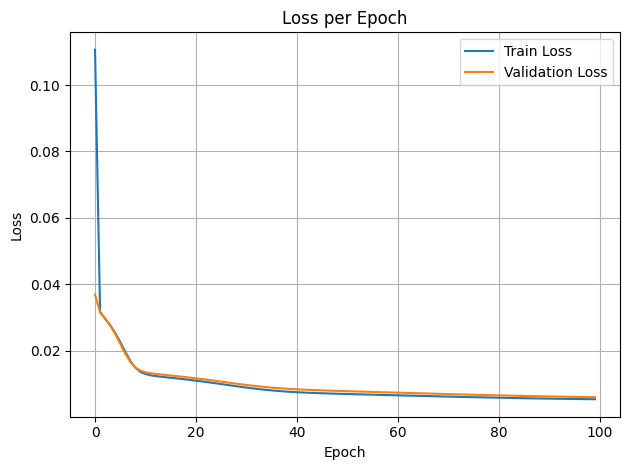

In [15]:
all_models = {
    "MarkovMLP": MarkovMLP(input_dim),
    "LSTM": LSTMModel(input_dim),
    "BiLSTM": BiLSTMModel(input_dim),
    "GRU": GRUModel(input_dim),
    "BiGRU": BiGRUModel(input_dim),
}

results = {}

for name, model in all_models.items():
    print(f"\n Training {name}...")

    if name == "MarkovMLP":
        res = train_markov_model(
            model,
            train_loader_m, val_loader_m, test_loader_m,
            epochs=100, initial_lr=0.005,
            dynamic_lr=False,
            optimizer_type='sgd'
        )
    else:
        res = train_and_evaluate(
            model,
            train_loader, val_loader, test_loader,
            epochs=100, initial_lr=0.005,
            dynamic_lr=False,
            optimizer_type='sgd'
        )

    results[name] = res


In [16]:
def display_model_results(results_dict, sort_by="MSE", save_csv=False, csv_path="model_results.csv"):
    df = pd.DataFrame(results_dict).T
    df = df.sort_values(by=sort_by)

    df_rounded = df.round(4)

    print("\n📊 Evaluation Results:\n")
    print(df_rounded)

    if save_csv:
        df_rounded.to_csv(csv_path)

    return df_rounded

In [17]:
final_table = display_model_results(results, sort_by="MSE", save_csv=True)


📊 Evaluation Results:

             Loss     MSE     MAE      R2  Cosine
MarkovMLP  0.0376  0.0030  0.0346 -0.4829  0.1568
GRU        0.0544  0.0062  0.0482 -0.8950  0.1449
BiGRU      0.0559  0.0063  0.0495 -1.1335  0.1442
BiLSTM     0.0675  0.0087  0.0588 -0.5596  0.1408
LSTM       0.0676  0.0090  0.0587 -0.3823  0.1405


In [18]:
input_length = 15
batch_size = 32
input_dim = 21

train_dataset = TimeSeriesDataset('/content/drive/MyDrive/selected_patient_time_series/train_normalized', input_length)
val_dataset = TimeSeriesDataset('/content/drive/MyDrive/selected_patient_time_series/val_normalized', input_length)
test_dataset = TimeSeriesDataset('/content/drive/MyDrive/selected_patient_time_series/test_normalized', input_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataset_m = MarkovDataset('/content/drive/MyDrive/selected_patient_time_series/train_normalized')
val_dataset_m = MarkovDataset('/content/drive/MyDrive/selected_patient_time_series/val_normalized')
test_dataset_m = MarkovDataset('/content/drive/MyDrive/selected_patient_time_series/test_normalized')
train_loader_m = DataLoader(train_dataset_m, batch_size=batch_size, shuffle=False)
val_loader_m = DataLoader(val_dataset_m, batch_size=batch_size, shuffle=False)
test_loader_m = DataLoader(test_dataset_m, batch_size=batch_size, shuffle=False)



 Training MarkovMLP...
Epoch  1/100 | Train: 0.00778826 | Val: 0.00229581 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.00176344 | Val: 0.00183238 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.00150632 | Val: 0.00187769 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Epoch  4/100 | Train: 0.00147757 | Val: 0.00188648 | LR: 1.00e-03 | No Improve: 1 | LR Patience: 1
Epoch  5/100 | Train: 0.00145969 | Val: 0.00176257 | LR: 1.00e-03 | No Improve: 2 | LR Patience: 2
Best model updated and saved.
Epoch  6/100 | Train: 0.00143277 | Val: 0.00166886 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.00140948 | Val: 0.00163243 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.00139885 | Val: 0.00163797 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Epoch  9/100 | Train: 0.00138054 |

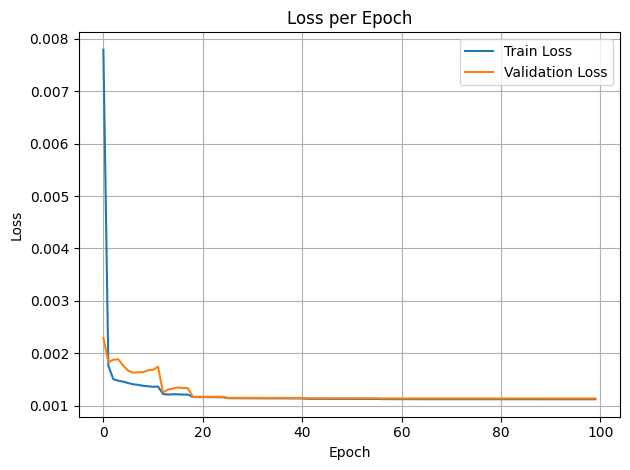


 Training LSTM...
Epoch  1/100 | Train: 0.01236449 | Val: 0.00802068 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.00515145 | Val: 0.00517211 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.00347161 | Val: 0.00352597 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  4/100 | Train: 0.00242747 | Val: 0.00248335 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  5/100 | Train: 0.00211224 | Val: 0.00208897 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  6/100 | Train: 0.00200570 | Val: 0.00196049 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.00183730 | Val: 0.00171008 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.00165599 | Val: 0.00168113 | LR: 1.00e-03 | No Improve

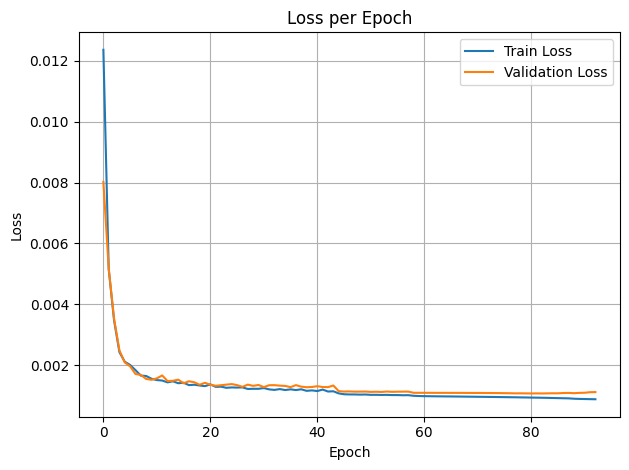


 Training BiLSTM...
Epoch  1/100 | Train: 0.01248836 | Val: 0.00820612 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.00506110 | Val: 0.00464470 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.00322420 | Val: 0.00278913 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  4/100 | Train: 0.00232672 | Val: 0.00243524 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  5/100 | Train: 0.00196727 | Val: 0.00199622 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  6/100 | Train: 0.00188133 | Val: 0.00187905 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.00167320 | Val: 0.00160191 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.00160863 | Val: 0.00182222 | LR: 1.00e-03 | No Impro

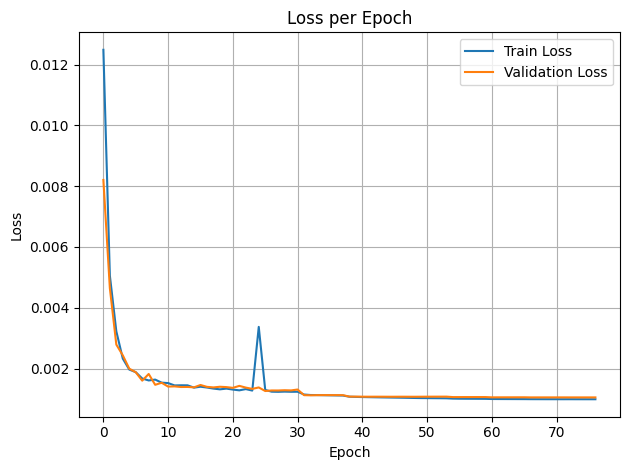


 Training GRU...
Epoch  1/100 | Train: 0.01110289 | Val: 0.00727477 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.00429142 | Val: 0.00342655 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.00286596 | Val: 0.00217900 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  4/100 | Train: 0.00192264 | Val: 0.00242456 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Epoch  5/100 | Train: 0.00197421 | Val: 0.00168858 | LR: 1.00e-03 | No Improve: 1 | LR Patience: 1
Best model updated and saved.
Epoch  6/100 | Train: 0.00176284 | Val: 0.00166549 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  7/100 | Train: 0.00169216 | Val: 0.00161900 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  8/100 | Train: 0.00160452 | Val: 0.00187051 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Epoch  9/1

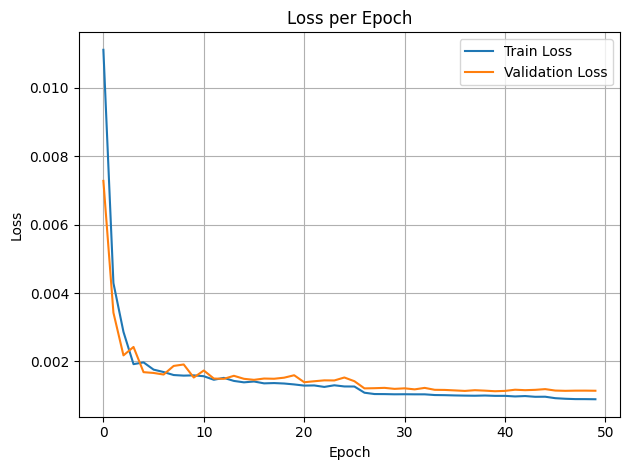


 Training BiGRU...
Epoch  1/100 | Train: 0.01090843 | Val: 0.00570835 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  2/100 | Train: 0.00400396 | Val: 0.00331393 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  3/100 | Train: 0.00257746 | Val: 0.00336548 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Epoch  4/100 | Train: 0.00219178 | Val: 0.00239416 | LR: 1.00e-03 | No Improve: 1 | LR Patience: 1
Best model updated and saved.
Epoch  5/100 | Train: 0.00197816 | Val: 0.00182466 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Best model updated and saved.
Epoch  6/100 | Train: 0.00175265 | Val: 0.00188163 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
Epoch  7/100 | Train: 0.00171745 | Val: 0.00284876 | LR: 1.00e-03 | No Improve: 1 | LR Patience: 1
Epoch  8/100 | Train: 0.00163952 | Val: 0.00158088 | LR: 1.00e-03 | No Improve: 2 | LR Patience: 2
Best model updated and saved.
Epoch  9/100 | Train: 0.00160158 | Val

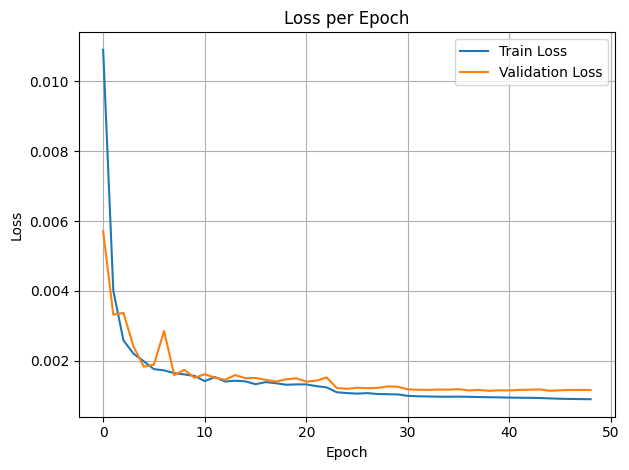

In [19]:
all_models = {
    "MarkovMLP": MarkovMLP(input_dim),
    "LSTM": LSTMModel(input_dim),
    "BiLSTM": BiLSTMModel(input_dim),
    "GRU": GRUModel(input_dim),
    "BiGRU": BiGRUModel(input_dim),
}

results = {}

for name, model in all_models.items():
    print(f"\n Training {name}...")

    if name == "MarkovMLP":
        res = train_markov_model(
            model,
            train_loader_m, val_loader_m, test_loader_m,
            epochs=100, initial_lr=0.001,
            dynamic_lr=True,
            optimizer_type='adam'
        )
    else:
        res = train_and_evaluate(
            model,
            train_loader, val_loader, test_loader,
            epochs=100, initial_lr=0.001,
            dynamic_lr=True,
            optimizer_type='adam'
        )

    results[name] = res


In [20]:
final_table = display_model_results(results, sort_by="MSE", save_csv=True)


📊 Evaluation Results:

             Loss     MSE     MAE      R2  Cosine
MarkovMLP  0.0141  0.0013  0.0128  0.8624  0.1628
BiLSTM     0.0165  0.0016  0.0149  0.8216  0.1437
GRU        0.0202  0.0019  0.0183  0.7087  0.1455
LSTM       0.0194  0.0020  0.0174  0.7928  0.1444
BiGRU      0.0196  0.0023  0.0173  0.8087  0.1446


### Plotting the results and analyzing the answers

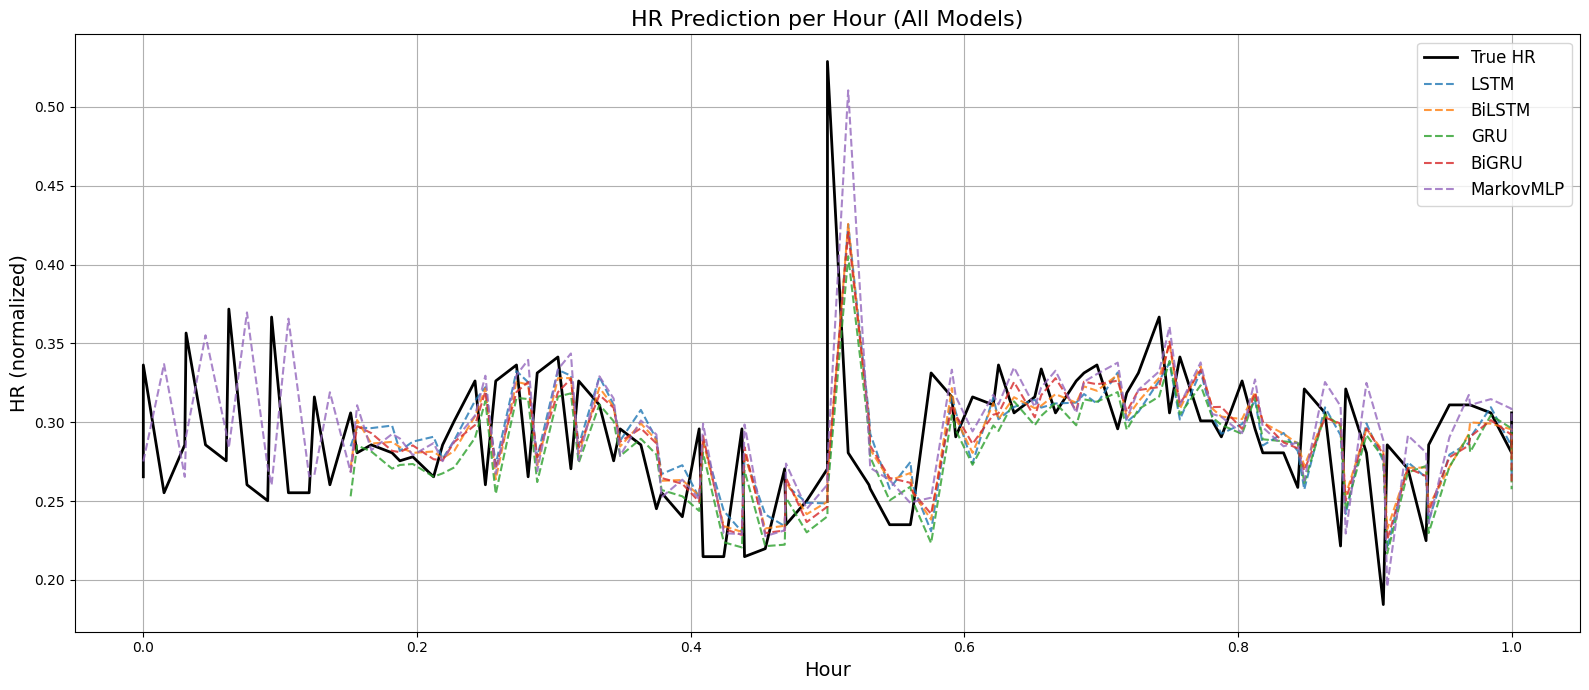

In [21]:
val_path = '/content/drive/MyDrive/selected_patient_time_series/val_normalized'
test_path = '/content/drive/MyDrive/selected_patient_time_series/test_normalized'



val_ids = set([f.split("_")[1].split(".")[0] for f in os.listdir(val_path) if f.endswith(".csv")])
test_ids = set([f.split("_")[1].split(".")[0] for f in os.listdir(test_path) if f.endswith(".csv")])


common_ids = list(val_ids.intersection(test_ids))

max_length = 0
longest_pid = None
for pid in common_ids:
    val_df = pd.read_csv(os.path.join(val_path, f"patient_{pid}.csv"))
    test_df = pd.read_csv(os.path.join(test_path, f"patient_{pid}.csv"))
    total_len = len(val_df) + len(test_df)
    if total_len > max_length:
        max_length = total_len
        longest_pid = pid
        longest_val_df = val_df
        longest_test_df = test_df

full_df = pd.concat([longest_val_df, longest_test_df], ignore_index=True)
full_df = full_df.sort_values(by="Hour").reset_index(drop=True)


seq_len = 15
feature_index = list(full_df.columns).index("HR")
hour_index = list(full_df.columns).index("Hour")

data = full_df.values.astype(np.float32)

X_seq, Y_hours = [], []
for i in range(len(data) - seq_len):
    X_seq.append(data[i:i+seq_len])
    Y_hours.append(data[i + seq_len][hour_index])
X_seq = np.stack(X_seq)
Y_hours = np.array(Y_hours)

X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)

models = {
    "LSTM": LSTMModel(input_dim).to(device),
    "BiLSTM": BiLSTMModel(input_dim).to(device),
    "GRU": GRUModel(input_dim).to(device),
    "BiGRU": BiGRUModel(input_dim).to(device),
    "MarkovMLP": MarkovMLP(input_dim).to(device),
}

for name, model in models.items():
    model.load_state_dict(torch.load(f"best_model_{model.__class__.__name__}.pt"))
    model.eval()

predictions = {}
for name, model in models.items():
    model.eval()
    if name == "MarkovMLP":
        preds, hours = [], []
        for i in range(len(data) - 1):
            x = torch.tensor(data[i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                y_pred = model(x).cpu().numpy().squeeze()
            preds.append(y_pred[feature_index])
            hours.append(data[i+1][hour_index])
        predictions[name] = (np.array(preds), np.array(hours))
    else:
        with torch.no_grad():
            y_pred = model(X_tensor).cpu().numpy()
        predictions[name] = (y_pred[:, feature_index], Y_hours)

true_hr = data[seq_len:, feature_index]
true_hour = data[seq_len:, hour_index]

plt.figure(figsize=(16, 7))

true_hr_full = data[:, feature_index]
true_hour_full = data[:, hour_index]
plt.plot(true_hour_full, true_hr_full, label='True HR', linewidth=2, color='black')


for name, (pred, hours) in predictions.items():
    linestyle = '--'
    plt.plot(hours, pred, label=name, linestyle=linestyle, linewidth=1.5, alpha=0.8)

plt.title("HR Prediction per Hour (All Models)", fontsize=16)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("HR (normalized)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### Maximum Log-Likelihood Estimation

In [31]:
# Parameters
window_size = 9
half_window = window_size // 2

# Paths
base_input = "/content/drive/MyDrive/selected_patient_time_series"
splits = {
    "train_normalized": "train_stats_window9",
    "val_normalized": "val_stats_window9",
    "test_normalized": "test_stats_window9"
}

# Process validation and test
for input_folder, output_folder in splits.items():
    input_dir = os.path.join(base_input, input_folder)
    output_dir = os.path.join(base_input, output_folder)
    os.makedirs(output_dir, exist_ok=True)

    for fname in tqdm(os.listdir(input_dir), desc=f"Processing {input_folder}"):
        if not fname.endswith(".csv"):
            continue

        file_path = os.path.join(input_dir, fname)
        df = pd.read_csv(file_path)

        # Drop Hour (column 0) and binary feature (column 3)
        df = df.drop(columns=[df.columns[0], df.columns[3]])

        # Rolling stats
        rolling_mean = df.rolling(window=window_size, center=True, min_periods=1).mean()
        rolling_var = df.rolling(window=window_size, center=True, min_periods=1).var()

        # Concatenate
        new_df = pd.concat([rolling_mean, rolling_var], axis=1)
        new_df.columns = [f"{col}_mean" for col in df.columns] + [f"{col}_var" for col in df.columns]

        # Save
        new_df.to_csv(os.path.join(output_dir, fname), index=False)



Processing test_normalized: 100%|██████████| 29/29 [00:00<00:00, 65.06it/s]


In [32]:
sample_val_path = os.path.join(base_input, "val_stats_window9")
sample_file = sorted(os.listdir(sample_val_path))[0]
sample_df = pd.read_csv(os.path.join(sample_val_path, sample_file))
print(f"Sample from: {sample_file}")
sample_df

Sample from: patient_100016.csv


,Unit2_mean,Unit1_mean,O2Sat_mean,EtCO2_mean,Resp_mean,MAP_mean,SBP_mean,HR_mean,DBP_mean,Temp_mean,...,Temp_var,Glucose_var,FiO2_var,Magnesium_var,Potassium_var,Creatinine_var,Calcium_var,Bilirubin_direct_var,Hct_var,BUN_var
0,0.0,1.0,0.985897,0.369665,0.218667,0.206985,0.314729,0.420946,0.133829,0.445467,...,0.000203,0.000016,2.533688e-10,5.448803e-07,0.000002,6.346155e-09,0.000004,1.812862e-10,0.000015,1.635259e-07
1,0.0,1.0,0.986111,0.368573,0.217778,0.208027,0.323643,0.421199,0.132590,0.443461,...,0.000187,0.000022,3.547164e-10,7.628324e-07,0.000003,8.884617e-09,0.000005,2.538006e-10,0.000022,2.289362e-07
2,0.0,1.0,0.988095,0.367482,0.218095,0.206145,0.312846,0.422104,0.133298,0.441218,...,0.000191,0.000030,4.729552e-10,1.017110e-06,0.000004,1.184616e-08,0.000007,3.384008e-10,0.000029,3.052483e-07
3,0.0,1.0,0.989583,0.366391,0.219167,0.240579,0.334302,0.422782,0.173792,0.438828,...,0.000209,0.000038,6.080852e-10,1.307713e-06,0.000005,1.523077e-08,0.000009,4.350868e-10,0.000037,3.924621e-07
4,0.0,1.0,0.990741,0.365299,0.225926,0.260008,0.344100,0.426125,0.197439,0.436339,...,0.000239,0.000090,7.601065e-10,1.634641e-06,0.000006,1.903846e-08,0.000011,5.438585e-10,0.000046,4.905776e-07
5,0.0,1.0,0.989316,0.363117,0.233333,0.277574,0.353144,0.432317,0.218092,0.429651,...,0.000120,0.000388,7.601065e-10,1.634641e-06,0.000006,1.903846e-08,0.000011,5.438585e-10,0.000046,4.905776e-07
6,0.0,1.0,0.990028,0.360934,0.234074,0.286560,0.348191,0.438227,0.231516,0.427880,...,0.000111,0.001058,7.601065e-10,1.634641e-06,0.000006,1.903846e-08,0.000011,5.438585e-10,0.000046,4.905776e-07
7,0.0,1.0,0.987892,0.358751,0.229630,0.298815,0.348191,0.439353,0.248864,0.427487,...,0.000102,0.001113,7.601065e-10,1.634641e-06,0.000006,1.903846e-08,0.000011,5.438585e-10,0.000046,4.905776e-07
8,0.0,1.0,0.986467,0.356569,0.235556,0.315155,0.353790,0.438227,0.269517,0.428470,...,0.000137,0.001105,7.601065e-10,1.634641e-06,0.000006,1.903846e-08,0.000011,5.438585e-10,0.000046,4.905776e-07
9,0.0,1.0,0.986467,0.354386,0.242222,0.345180,0.366925,0.438790,0.306485,0.430831,...,0.000243,0.001463,7.601065e-10,1.634641e-06,0.000006,1.903846e-08,0.000011,5.438585e-10,0.000046,4.905776e-07


In [55]:
input_dim = 38       # 19 میانگین + 19 واریانس
feature_dim = 19     # فقط 19 ویژگی واقعی داریم
hidden_dim = 128
batch_size = 32
seq_len = 15

class LSTMStatsModel(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # خروجی میانگین‌ها و واریانس‌ها (هرکدوم فقط feature_dim تا ویژگی دارن)
        self.fc_mean = nn.Linear(hidden_dim, feature_dim)
        self.fc_var = nn.Linear(hidden_dim, feature_dim)

    def forward(self, x):
        out, _ = self.lstm(x)              # out: (batch, seq_len, hidden_dim)
        last_hidden = out[:, -1, :]        # (batch, hidden_dim)

        mu = self.fc_mean(last_hidden)     # (batch, feature_dim)
        sigma = F.softplus(self.fc_var(last_hidden))  # positive variance (batch, feature_dim)

        return mu, sigma

model = LSTMStatsModel(input_dim=input_dim, feature_dim=feature_dim, hidden_dim=hidden_dim).to(device)

summary(model, input_size=(batch_size, seq_len, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMStatsModel                           [32, 19]                  --
├─LSTM: 1-1                              [32, 15, 128]             86,016
├─Linear: 1-2                            [32, 19]                  2,451
├─Linear: 1-3                            [32, 19]                  2,451
Total params: 90,918
Trainable params: 90,918
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 41.44
Input size (MB): 0.07
Forward/backward pass size (MB): 0.50
Params size (MB): 0.36
Estimated Total Size (MB): 0.94

In [37]:
class TimeSeriesStatsDataset(Dataset):
    def __init__(self, data_dir, input_length):
        self.samples = []
        for fname in os.listdir(data_dir):
            if not fname.endswith(".csv"):
                continue
            df = pd.read_csv(os.path.join(data_dir, fname)).values.astype(np.float32)
            for i in range(len(df) - input_length):
                x = df[i:i+input_length]
                y = df[i+input_length]
                mu_target = y[:x.shape[1] // 2]     # اولین نصف
                sigma_target = y[x.shape[1] // 2:]  # دومین نصف
                self.samples.append((x, mu_target, sigma_target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, mu, sigma = self.samples[idx]
        return torch.tensor(x), torch.tensor(mu), torch.tensor(sigma)


In [38]:
input_length = 6
batch_size = 32
input_dim = 38

train_dataset = TimeSeriesStatsDataset('/content/drive/MyDrive/selected_patient_time_series/train_stats_window9', input_length)
val_dataset = TimeSeriesStatsDataset('/content/drive/MyDrive/selected_patient_time_series/val_stats_window9', input_length)
test_dataset = TimeSeriesStatsDataset('/content/drive/MyDrive/selected_patient_time_series/test_stats_window9', input_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
def train_mle_model(
    model, train_loader, val_loader, test_loader,
    epochs=50, initial_lr=5e-3, min_lr=1e-5, lr_patience=5, early_stop_patience=10,
    dynamic_lr=True, optimizer_type='adam'
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr) if optimizer_type.lower() == 'adam' \
        else torch.optim.SGD(model.parameters(), lr=initial_lr)

    best_val_loss = float('inf')
    best_model_state = None
    train_losses, val_losses = [], []
    no_improve_epochs = 0
    lr_no_improve = 0
    current_lr = initial_lr

    def mle_loss(mu_pred, sigma_pred, mu_true, sigma_true, eps=1e-6):
        # Ensure numerical stability
        sigma_pred = sigma_pred + eps
        log_sigma = torch.log(sigma_pred)
        squared_diff = (mu_pred - mu_true) ** 2
        loss = log_sigma + squared_diff / (2 * sigma_pred**2)
        return loss.mean()

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x, mu_target, sigma_target in train_loader:
            x, mu_target, sigma_target = to_device(x), to_device(mu_target), to_device(sigma_target)
            mu_pred, sigma_pred = model(x)
            loss = mle_loss(mu_pred, sigma_pred, mu_target, sigma_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, mu_target, sigma_target in val_loader:
                x, mu_target, sigma_target = to_device(x), to_device(mu_target), to_device(sigma_target)
                mu_pred, sigma_pred = model(x)
                loss = mle_loss(mu_pred, sigma_pred, mu_target, sigma_target)
                total_val_loss += loss.item()

        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:>2}/{epochs} | Train: {train_loss:.6f} | Val: {val_loss:.6f} | LR: {current_lr:.2e} "
              f"| No Improve: {no_improve_epochs} | LR Patience: {lr_no_improve}")

        # Early stopping + saving best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve_epochs = 0
            lr_no_improve = 0
            torch.save(best_model_state, f"best_model_{model.__class__.__name__}.pt")
            print("✅ Best model saved.")
        else:
            no_improve_epochs += 1
            lr_no_improve += 1

        if dynamic_lr and lr_no_improve >= lr_patience:
            current_lr = max(current_lr / 2, min_lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            print("📉 Learning rate reduced.")
            lr_no_improve = 0

        if no_improve_epochs >= early_stop_patience:
            print(f"⏹ Early stopping at epoch {epoch+1}")
            break

    # Plot Loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("MLE Loss per Epoch")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluation
    model.load_state_dict(torch.load(f"best_model_{model.__class__.__name__}.pt"))
    model.eval()
    y_true_mu, y_pred_mu = [], []
    with torch.no_grad():
        for x, mu_target, sigma_target in test_loader:
            x = to_device(x)
            mu_pred, _ = model(x)
            y_pred_mu.append(mu_pred.cpu())
            y_true_mu.append(mu_target.cpu())

    y_true_mu = torch.cat(y_true_mu).numpy()
    y_pred_mu = torch.cat(y_pred_mu).numpy()

    metrics = {
        'Loss': mean_squared_error(y_true_mu, y_pred_mu) + mean_absolute_error(y_true_mu, y_pred_mu),
        'MSE': mean_squared_error(y_true_mu, y_pred_mu),
        'MAE': mean_absolute_error(y_true_mu, y_pred_mu),
        'R2': r2_score(y_true_mu, y_pred_mu),
        'Cosine': 1 - cosine_similarity(y_true_mu, y_pred_mu).mean()
    }
    return metrics


Epoch  1/100 | Train: -1.844458 | Val: -2.038266 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
✅ Best model saved.
Epoch  2/100 | Train: -2.160663 | Val: -2.085863 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
✅ Best model saved.
Epoch  3/100 | Train: -2.384555 | Val: -2.167869 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
✅ Best model saved.
Epoch  4/100 | Train: -2.577052 | Val: -2.404413 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
✅ Best model saved.
Epoch  5/100 | Train: -2.744894 | Val: -2.685073 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
✅ Best model saved.
Epoch  6/100 | Train: -2.922609 | Val: -2.794017 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
✅ Best model saved.
Epoch  7/100 | Train: -3.054864 | Val: -2.974654 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
✅ Best model saved.
Epoch  8/100 | Train: -3.171399 | Val: -3.145660 | LR: 1.00e-03 | No Improve: 0 | LR Patience: 0
✅ Best model saved.
Epoch  9/100 | Train: -3.281928 | Val: -3.326983 | LR: 1.00e-03 

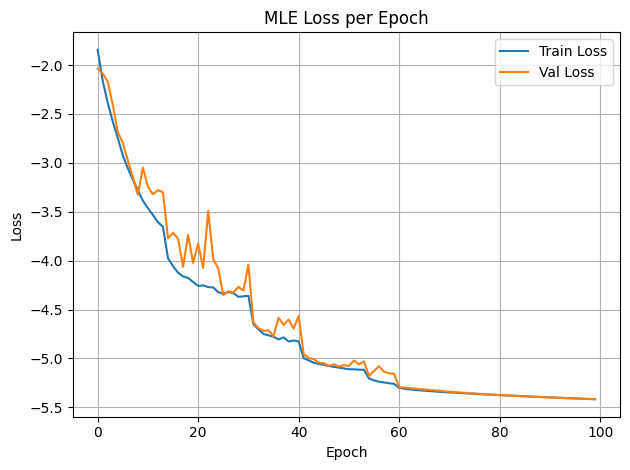

Evaluation Metrics: {'Loss': 0.0024219119568442693, 'MSE': 1.6919488189159892e-05, 'MAE': 0.0024049924686551094, 'R2': 0.9518901705741882, 'Cosine': np.float32(0.1377809)}


In [59]:
model = LSTMStatsModel(input_dim=input_dim, feature_dim=feature_dim, hidden_dim=hidden_dim).to(device)
results = train_mle_model(
    model,
    train_loader, val_loader, test_loader,
    epochs=100,
    initial_lr=1e-3,
    dynamic_lr=True,
    optimizer_type='adam'
)
print("Evaluation Metrics:", results)


In [60]:
full_df

,Hour,Unit2,Unit1,SepsisLabel,O2Sat,EtCO2,Resp,MAP,SBP,HR,...,Temp,Glucose,FiO2,Magnesium,Potassium,Creatinine,Calcium,Bilirubin_direct,Hct,BUN
0,0.000000,0.296736,0.703264,0,0.974359,0.2617,0.266667,0.198529,0.248062,0.265417,...,0.575779,0.249393,0.982926,0.247354,0.299320,0.068521,0.386168,0.251317,0.347482,0.168841
1,0.000000,0.097923,0.902077,0,0.935897,0.2617,0.440000,0.246324,0.387597,0.336342,...,0.637394,0.268853,0.985060,0.269841,0.295918,0.062811,0.407216,0.267316,0.332553,0.178261
2,0.015152,0.293769,0.706231,0,0.955128,0.2617,0.260000,0.202206,0.248062,0.255285,...,0.558074,0.246285,0.982926,0.246032,0.295918,0.068521,0.384021,0.251556,0.346019,0.169565
3,0.030303,0.290801,0.709199,0,1.000000,0.2617,0.266667,0.220588,0.360465,0.285681,...,0.564093,0.243178,0.982926,0.244709,0.299320,0.068521,0.381873,0.251795,0.344555,0.170290
4,0.031250,0.094955,0.905045,0,0.897436,0.2617,0.386667,0.257353,0.391473,0.356607,...,0.637394,0.252761,0.985060,0.269841,0.293878,0.061859,0.406357,0.267555,0.332358,0.177174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.968750,0.005935,0.994065,0,1.000000,0.2617,0.266667,0.305147,0.488372,0.311012,...,0.607042,0.359125,0.984794,0.243386,0.340136,0.215080,0.388316,0.274719,0.350436,0.260870
96,0.969697,0.106825,0.893175,0,0.923077,0.2617,0.413333,0.235294,0.372093,0.311012,...,0.635269,0.207037,0.985060,0.269841,0.282799,0.064239,0.402062,0.266600,0.333138,0.182609
97,0.984848,0.103858,0.896142,0,0.935897,0.2617,0.306667,0.238971,0.399225,0.305946,...,0.637394,0.227642,0.985060,0.269841,0.287172,0.063763,0.403780,0.266838,0.332943,0.181159
98,1.000000,0.002967,0.997033,0,1.000000,0.2617,0.280000,0.242647,0.306202,0.280615,...,0.576690,0.382020,0.984527,0.241623,0.349206,0.242362,0.387743,0.274957,0.351501,0.276812


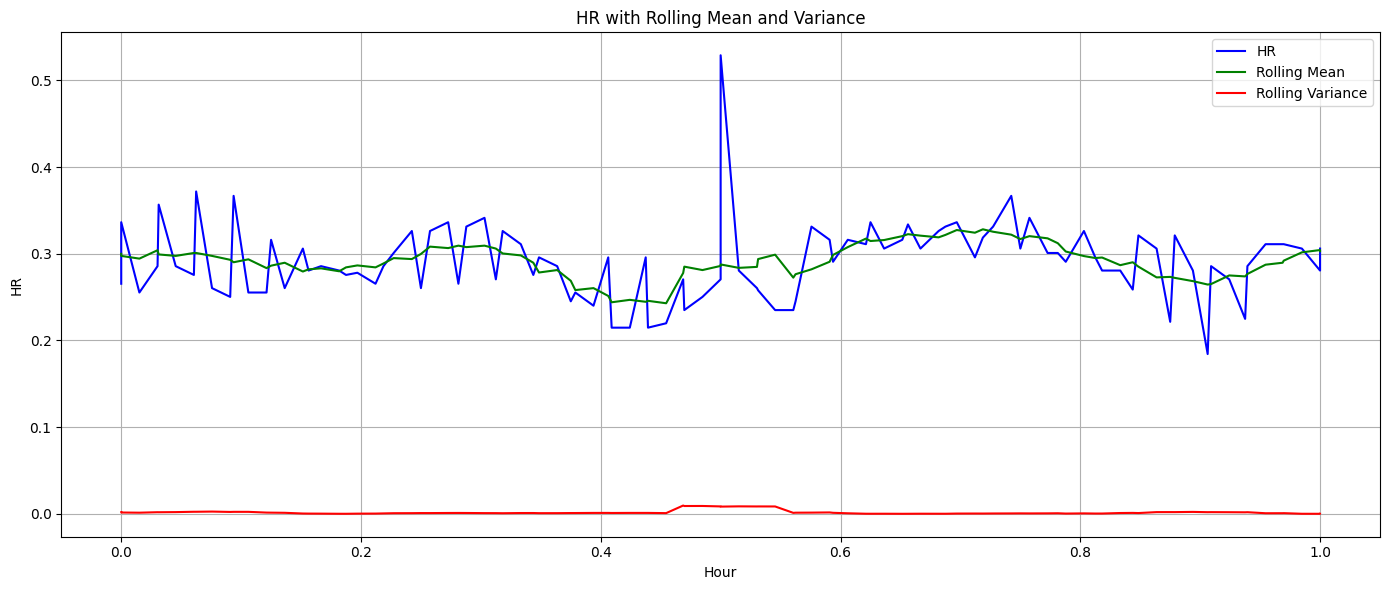

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

hour = full_df.iloc[:, 0]
hr = full_df.iloc[:, 9]


rolling_window = 9
rolling_mean = hr.rolling(window=rolling_window, center=True, min_periods=1).mean()
rolling_var = hr.rolling(window=rolling_window, center=True, min_periods=1).var()


stats_df = pd.DataFrame({
    'Hour': hour,
    'HR': hr,
    'HR_mean': rolling_mean,
    'HR_var': rolling_var
})


plt.figure(figsize=(14, 6))
plt.plot(hour, hr, label='HR', color='blue')
plt.plot(hour, rolling_mean, label='Rolling Mean', color='green')
plt.plot(hour, rolling_var, label='Rolling Variance', color='red')
plt.xlabel('Hour')
plt.ylabel('HR')
plt.title('HR with Rolling Mean and Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


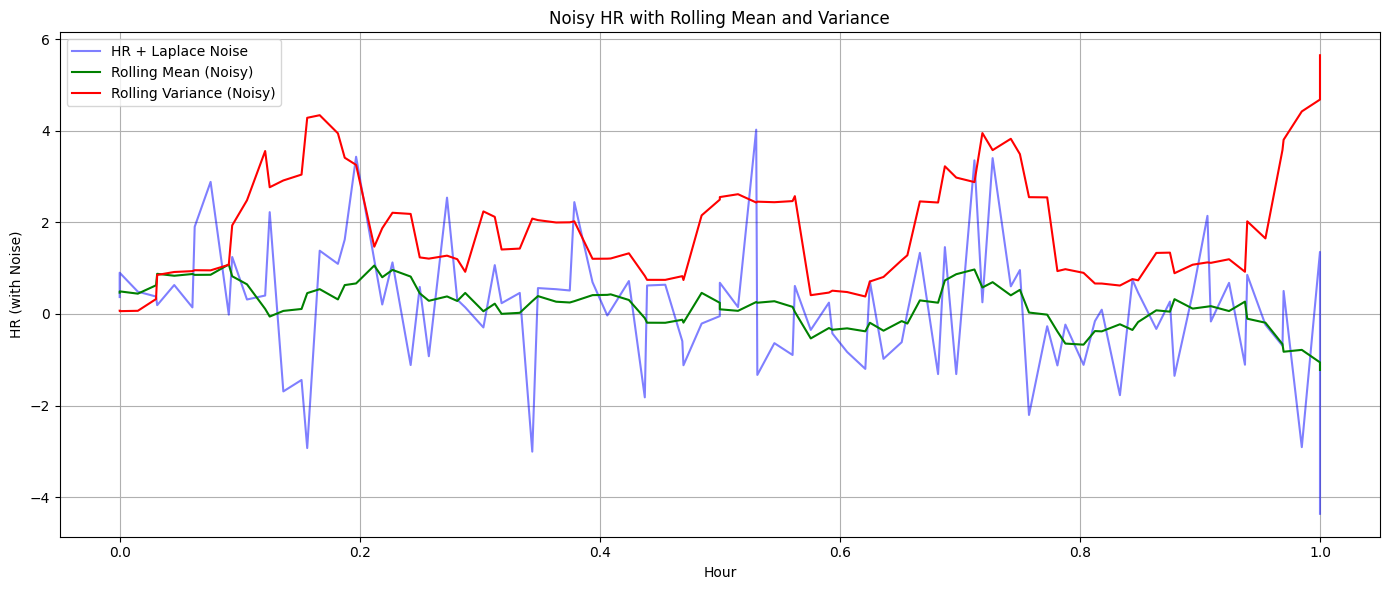

In [64]:
np.random.seed(0)
noise_scale = 1.0

hour = full_df.iloc[:, 0]
hr = full_df.iloc[:, 9]

laplace_noise = np.random.laplace(loc=0.0, scale=noise_scale, size=len(hr))
hr_noisy = hr + laplace_noise


rolling_window = 9
rolling_mean_noisy = pd.Series(hr_noisy).rolling(window=rolling_window, center=True, min_periods=1).mean()
rolling_var_noisy = pd.Series(hr_noisy).rolling(window=rolling_window, center=True, min_periods=1).var()


noisy_df = pd.DataFrame({
    'Hour': hour,
    'HR_noisy': hr_noisy,
    'HR_noisy_mean': rolling_mean_noisy,
    'HR_noisy_var': rolling_var_noisy
})

plt.figure(figsize=(14, 6))
plt.plot(hour, hr_noisy, label='HR + Laplace Noise', color='blue', alpha=0.5)
plt.plot(hour, rolling_mean_noisy, label='Rolling Mean (Noisy)', color='green')
plt.plot(hour, rolling_var_noisy, label='Rolling Variance (Noisy)', color='red')
plt.xlabel('Hour')
plt.ylabel('HR (with Noise)')
plt.title('Noisy HR with Rolling Mean and Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

noisy_df.to_csv('/content/drive/MyDrive/HR_noisy_stats.csv', index=False)
